In [1]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 72.4 MB/s 
     |████████████████████████████████| 81 kB 11.7 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 112 kB 79.1 MB/s 
     |████████████████████████████████| 49 kB 8.1 MB/s 
     |████████████████████████████████| 146 kB 85.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=0b7f0476c0a12dfc19b0cd33aa88cc52deb86fb0d080337e395bc5e17d27ec58
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 78.0 M

In [2]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

logger = TensorBoardLogger('.', name = 'TFT')

from datetime import datetime

save_path = '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/'
datetime.today()
today = datetime.today()
str_today = today.strftime('%y%m%d%H%M')
save_model = save_path + str_today + '_TFT_key_saved_model.pth'
save_best_model = save_path + str_today + '_TFT_key_saved_best_model.pth'
print(save_model)
print(save_best_model)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206220641_TFT_key_saved_model.pth
/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206220641_TFT_key_saved_best_model.pth


In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_step_v2.pickle', 'rb') as f:
    data = pickle.load(f)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1707 entries, 0 to 1706
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1707 non-null   datetime64[ns]
 1   market              1707 non-null   object        
 2   change_price        1707 non-null   float64       
 3   prev_closing_price  1707 non-null   float64       
 4   cmdt_cc             1707 non-null   float64       
 5   fx_gbpusd           1707 non-null   float64       
 6   kr_holiday          1707 non-null   object        
 7   us_holiday          1707 non-null   object        
 8   dayofweek           1707 non-null   category      
 9   month               1707 non-null   category      
 10  dominant_topic      1707 non-null   category      
 11  trade_price         1707 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(5), object(3)
memory usage: 138.7+ KB


In [4]:
# drop_col = ['us_holiday']
# data_t = data.drop(drop_col, axis=1)
# # data['keyword'] = data['keyword'].str.replace("<"," ")
data_t = data.copy()
data_t['date'] = pd.to_datetime(data_t['date'], format='%Y-%m-%d')
data_t = data_t.sort_values('date').reset_index(drop=True)
data_t['time_index'] = np.arange(len(data))
data_t['time_index'] = data_t['time_index'].astype(int)
data_t['market'] = data_t['market'].astype(str).astype("category")


data_t['kr_holiday'] = data_t['kr_holiday'].apply(lambda x : x.replace('.',''))

holi_df = pd.get_dummies(data_t['kr_holiday'])
holi_df = holi_df.drop(columns='-')
kr_special_days = holi_df.columns.tolist()

holi_df[kr_special_days] = (
    holi_df[kr_special_days]
    .apply(lambda x: x.map({0: "-", 1: x.name}))
    .astype("category")
)

res_data = pd.concat([data_t.drop(columns = ['us_holiday','kr_holiday']), holi_df], axis=1)

In [ ]:
res_data.head(5)

,date,market,change_price,prev_closing_price,cmdt_cc,fx_gbpusd,dayofweek,month,dominant_topic,trade_price,...,Liberation Day,Lunar New Year's Day,Memorial Day,National Foundation Day,"National Foundation Day, The day preceding of Chuseok",New Year's Day,The day preceding of Chuseok,The day preceding of Lunar New Year's Day,The second day of Chuseok,The second day of Lunar New Year's Day
0,2017-09-25,KRW-ETH,-3500.0,325000.0,1972.0,1.3497,0,9,15.0,325000.0,...,-,-,-,-,-,-,-,-,-,-
1,2017-09-26,KRW-ETH,-3500.0,325000.0,1971.0,1.3418,1,9,15.0,321500.0,...,-,-,-,-,-,-,-,-,-,-
2,2017-09-27,KRW-ETH,21000.0,321500.0,2015.0,1.3396,2,9,15.0,342500.0,...,-,-,-,-,-,-,-,-,-,-
3,2017-09-28,KRW-ETH,-10000.0,342500.0,1980.0,1.3445,3,9,15.0,332500.0,...,-,-,-,-,-,-,-,-,-,-
4,2017-09-29,KRW-ETH,-5000.0,332500.0,2043.0,1.3408,4,9,2.0,327500.0,...,-,-,-,-,-,-,-,-,-,-


In [ ]:
def objective(trial):

    cfg = { 'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0),
            'hidden_size' : trial.suggest_categorical('hidden_size', [16,32, 64,128,256,512,1024]),
            'hidden_continuous_size' : trial.suggest_categorical('hidden_continuous_size', [16,32,64,128,256,512,1024]),
            'attention_head_size' : trial.suggest_int('attention_head_size', 2, 7, 1),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 1e-0),
             'dropout' : trial.suggest_categorical('dropout', [0,0.1,0.2])
        }


    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 60
    max_prediction_length = 20

    output_size = 7
    log_interval = 10
    limit_train_batches = 50
    batch_size = 128
    gpus = 1
    max_epochs = 30
    reduce_on_plateau_patience = 4


    training_cutoff = res_data['time_index'].max() - max_prediction_length
    # training_cutoff = int(res_data['time_index'].max() * .7)


    training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="trade_price",
            group_ids=["market"], 
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], 
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=["dayofweek", "month","kr_special_days","dominant_topic"], #'kr_holiday','us_holiday'], #["special_days", "month"],
            variable_groups= {"kr_special_days" : kr_special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            time_varying_unknown_categoricals=[],     
            time_varying_unknown_reals=[
                "trade_price",                        
                # "change_price",
                # 'prev_closing_price',
                # 'cmdt_cc',
                'fx_gbpusd'
            ],
            target_normalizer=GroupNormalizer(
                groups=["market"], transformation="softplus"
            ), 
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()

    print(f'mae_with_baseline : {mae_with_baseline}')
    print(f'Baseline SMAPE : {SMAPE()(baseline_predictions, actuals)}')


    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate = cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size = cfg['hidden_continuous_size'],
        dropout = cfg['dropout'],
        attention_head_size = cfg['attention_head_size'],
        output_size = output_size,  # 7 quantiles by default
        loss = QuantileLoss(),
        log_interval = log_interval,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience = reduce_on_plateau_patience,
    )

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate


    trainer = pl.Trainer(
        max_epochs = max_epochs,
        gpus = gpus,
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  limit_train_batches, # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )

    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    torch.save(best_model.state_dict(), save_model)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)

    return SMAPE()(predictions, actuals)

In [ ]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=25)

In [ ]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_step_220622_01.pkl')

['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_step_220622_01.pkl']

In [ ]:
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_step_220622_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.08512932062149048
 Params: 
    learning_rate: 0.00011001554178810748
    hidden_size: 128
    hidden_continuous_size: 32
    attention_head_size: 5
    gradient_clip_val: 0.37186794669924966
    dropout: 0.2


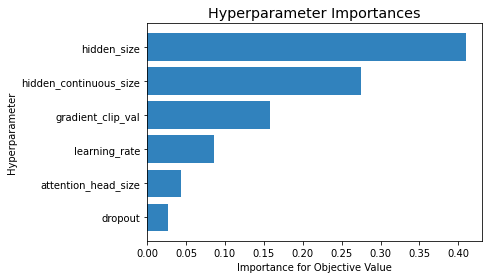

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

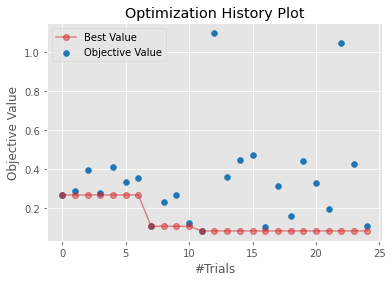



Number of finished trials:  25
Best trial:
  Value:  0.08512932062149048
  Params: 
    learning_rate: 0.00011001554178810748
    hidden_size: 128
    hidden_continuous_size: 32
    attention_head_size: 5
    gradient_clip_val: 0.37186794669924966
    dropout: 0.2


In [ ]:
# show best hyperparameters
# print(study.best_trial.params)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()
print("\n")


print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 60    # encoder LSTM에 들어가는 길이
max_prediction_length = 20 # decoder의 길이


output_size = 7
log_interval = 10
limit_train_batches = 30
batch_size = 128
gpus = 1
max_epochs = 50
reduce_on_plateau_patience = 4

training_cutoff = res_data['time_index'].max() - max_prediction_length
# training_cutoff = int(res_data['time_index'].max() * .7)


training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="trade_price",
            group_ids=["market"], 
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], 
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=['dayofweek', 'month',"kr_special_days","dominant_topic"], #'kr_holiday','us_holiday'], #["special_days", "month"],
            variable_groups= {"kr_special_days" : kr_special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            time_varying_unknown_categoricals=[],     
            time_varying_unknown_reals=[
                "trade_price",                        
                # "change_price",
                # 'prev_closing_price',
                # 'cmdt_cc',
                'fx_gbpusd'
            ],
            target_normalizer=GroupNormalizer(
                groups=["market"], transformation="softplus"
            ), 
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    dropout = study.best_params['dropout'],
    attention_head_size = study.best_params['attention_head_size'],
    output_size = output_size,  # 7 quantiles by default
    loss = QuantileLoss(),
    log_interval = log_interval,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience = reduce_on_plateau_patience,
)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate


trainer = pl.Trainer(
    max_epochs = max_epochs,
    gpus = gpus,
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  limit_train_batches, # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger = TensorBoardLogger('.', name = 'best_tft')
)

print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")        


# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


#### Evaluate performance

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

torch.save(best_model.state_dict(), save_best_model )

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions, _ = best_model.predict(val_dataloader, return_x=True)
# predictions = best_model.predict(val_dataloader)

SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()
print(f'SMAPE : {SMAPE}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 448   
4  | static_variable_selection          | VariableSelectionNetwork        | 34.6 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 49.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 927.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

SMAPE : 0.35496705770492554


In [ ]:
actuals

tensor([[3038000., 3095000., 2884000., 2648000., 2694000., 2733000., 2806000.,
         2660000., 2695000., 2472000., 2583000., 2538000., 2552000., 2627000.,
         2533000., 2525000., 2494000., 2314000., 2225000., 2286000.]])

In [ ]:
predictions

tensor([[3336081.2500, 3468113.2500, 3589796.7500, 3659319.7500, 3763233.0000,
         3883140.0000, 3578411.7500, 3880943.0000, 3769492.5000, 3924058.7500,
         3697367.7500, 3791548.2500, 3921524.7500, 3581392.5000, 3912067.7500,
         3775694.2500, 3938580.0000, 3708933.7500, 3799961.5000, 3939137.5000]])

In [ ]:
# # 2206211940_TFT_key_saved_model.pth
# # /content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_step_220622_01.pk

# # best_load_model load

# best_load_model = TemporalFusionTransformer()
# best_load_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206211940_TFT_key_saved_model.pth'))
# best_load_model.eval()


# print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")


# actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# raw_predictions, x = best_load_model.predict(val_dataloader, mode="raw", return_x=True)

# for idx in range(1):  # plot 10 examples
#     best_load_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# print(f'MAE : {(actuals - raw_predictions).abs().mean()}')

# SMAPE = (2 * (raw_predictions - actuals).abs() / (raw_predictions.abs() + actuals.abs() + 1e-8)).mean()
# print(f'SMAPE : {SMAPE}')

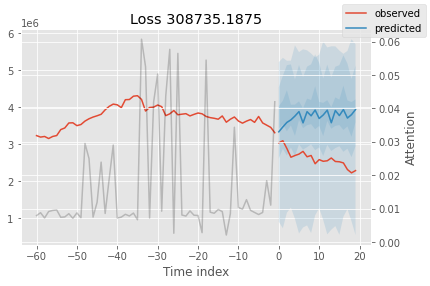

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

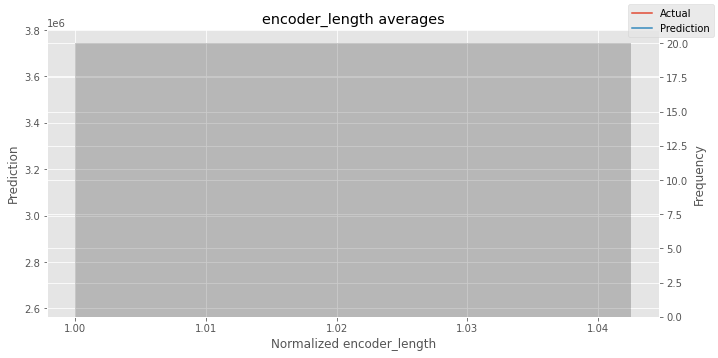

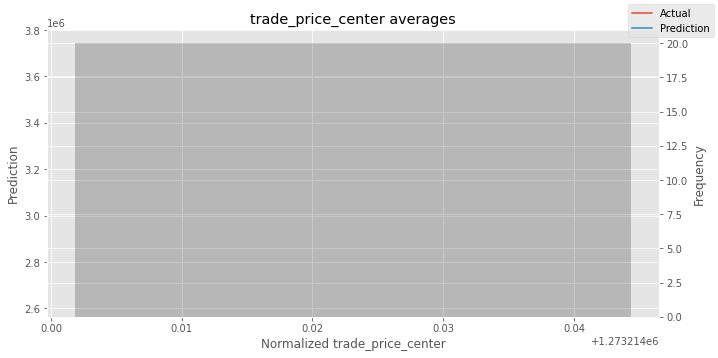

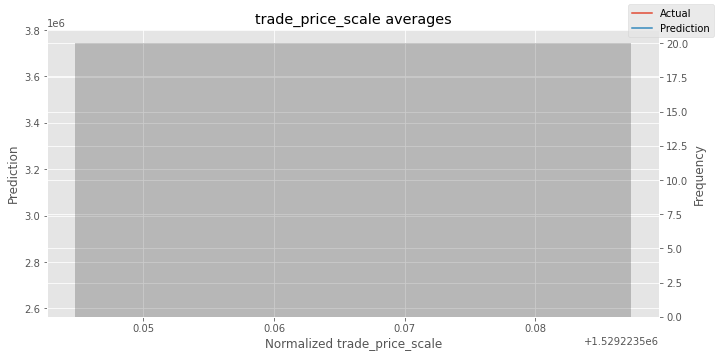

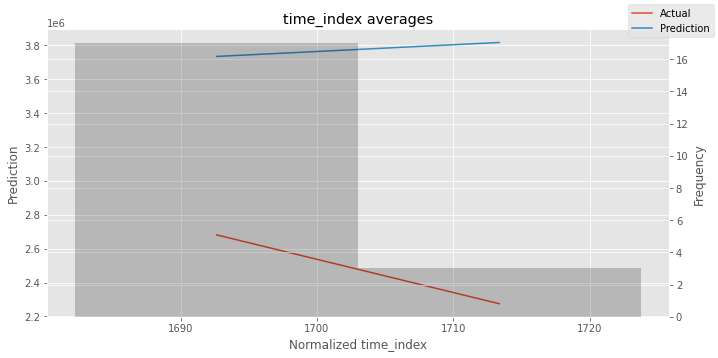

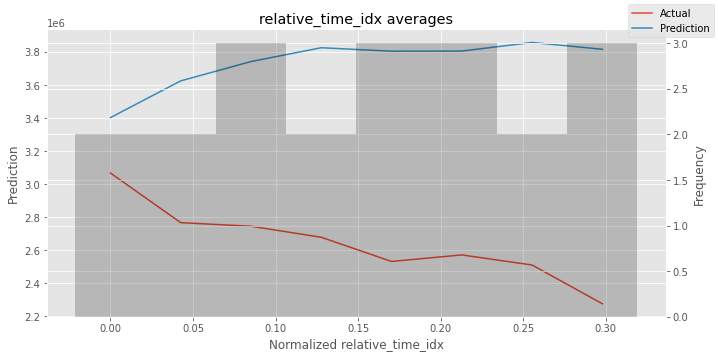

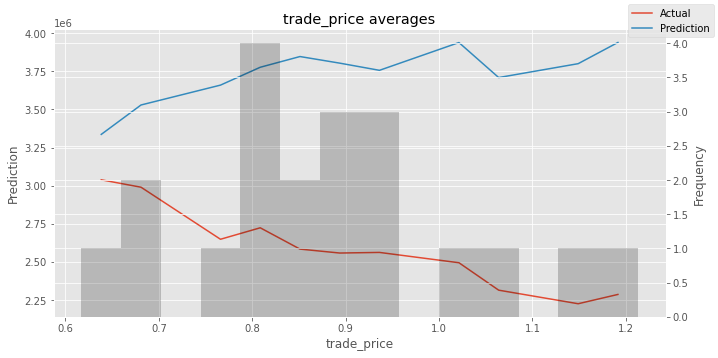

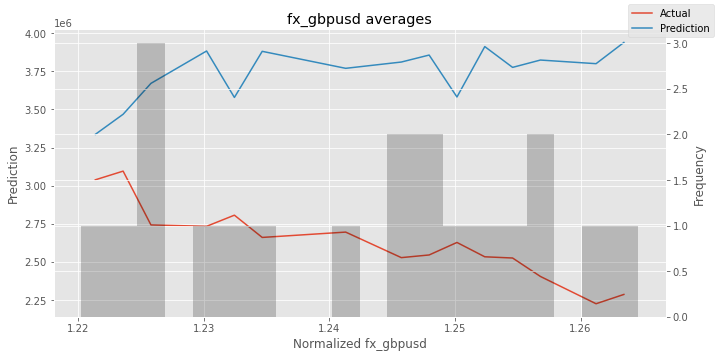

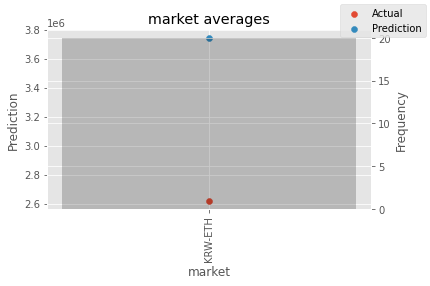

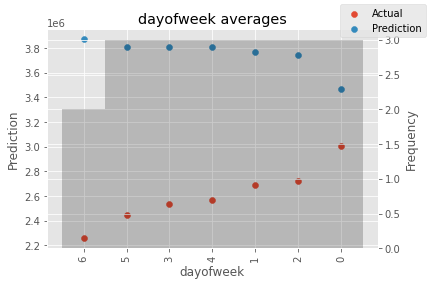

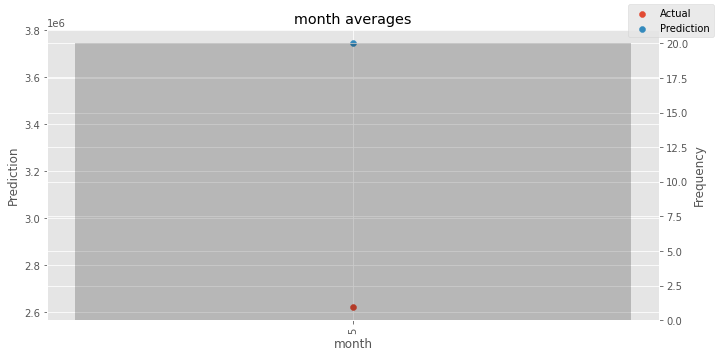

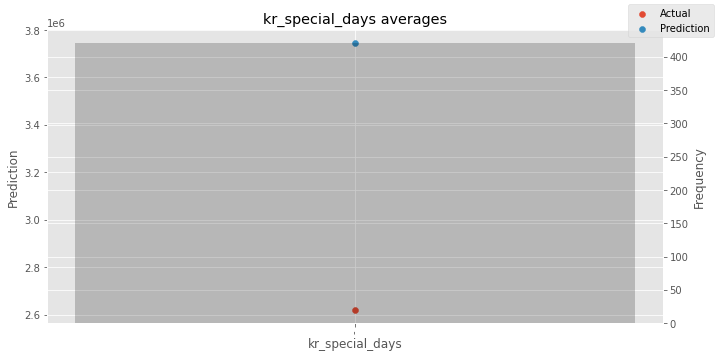

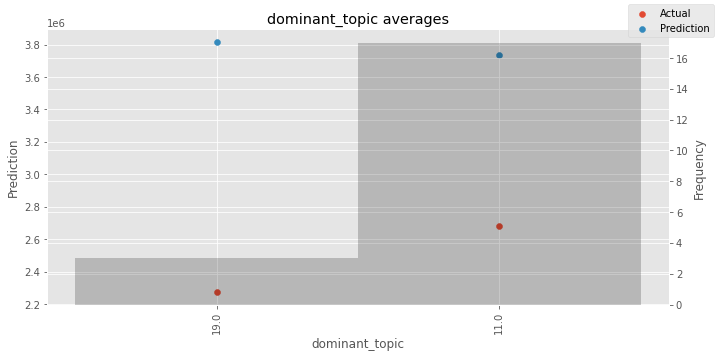

In [ ]:
predictions, x = best_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_model.calculate_prediction_actual_by_variable(x, predictions)
best_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>}

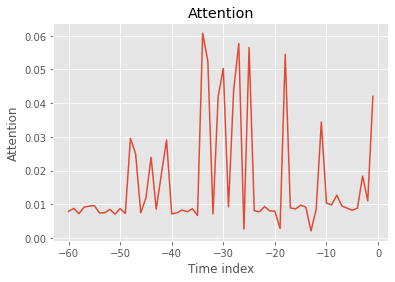

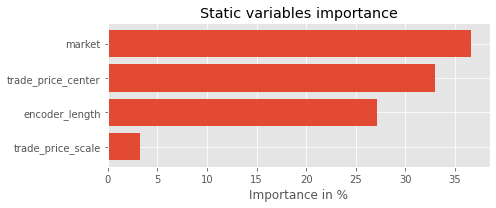

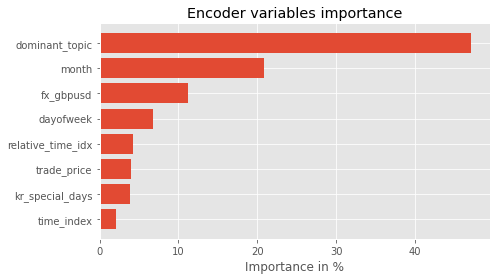

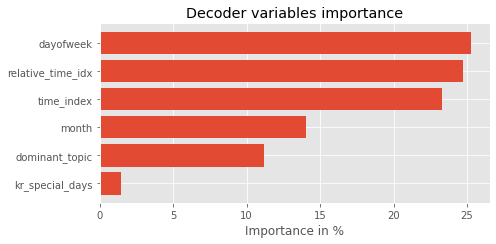

In [ ]:
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")
best_model.plot_interpretation(interpretation)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

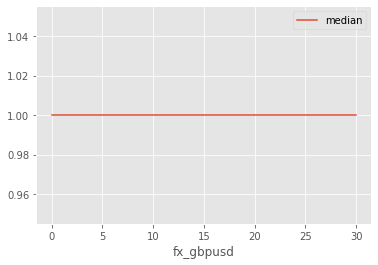

In [ ]:
dependency = best_model.predict_dependency(
    val_dataloader.dataset, "fx_gbpusd", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("fx_gbpusd").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

In [ ]:
# # best_load_model load

# best_load_model = TemporalFusionTransformer()
# best_load_model.load_state_dict(torch.load(save_best_model))
# best_load_model.eval()


# print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")


# actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# raw_predictions, x = best_load_model.predict(val_dataloader, mode="raw", return_x=True)

# for idx in range(1):  # plot 10 examples
#     best_load_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# print(f'MAE : {(actuals - raw_predictions).abs().mean()}')

# SMAPE = (2 * (raw_predictions - actuals).abs() / (raw_predictions.abs() + actuals.abs() + 1e-8)).mean()
# print(f'SMAPE : {SMAPE}')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=best_tft/

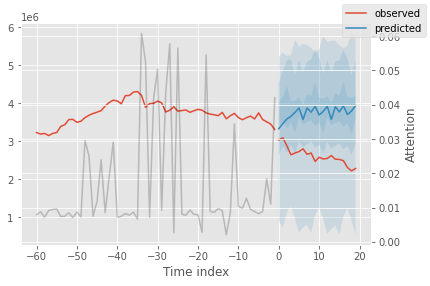

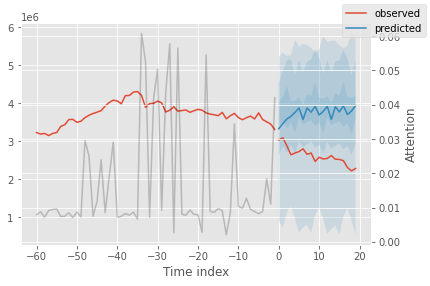

In [ ]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)